# Model comparison
This week we will introduce two main concepts: noise ceiling estimation and variance partitioning. We will blaze by a few difficult concepts that will be addressed in greater depth in an auxiliary notebook, which you should run through over spring break. These auxiliary notebooks will contain many more basic python exercises, which are meant to help you get more comfortable with the idioms of python code that are often used in this class. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# For visualization of data
import cortex as cx
# For loading hdf5 files in python
import h5py
# Some utility functions in a file in this directory:
import utils

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The data is stored in hdf format, which is a generic data storage format that is compatible with both matlab and python (using the h5py or tables libraries). You can read more about the file specification on the [hdf5 support page](https://portal.hdfgroup.org/display/HDF5/HDF5) or the [wikipedia page about hdf format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)

The files we will be inspecting are all in `/unrshare/LESCROARTSHARE/IntroToEncodingModels/`. Let's see what's there:

In [2]:
ls /unrshare/LESCROARTSHARE/IntroToEncodingModels/

catloc_design.hdf*                 s01_color_natims_data*
color_natims_features_19cat.hdf*   s01_color_natims_data.hdf*
color_natims_features_19cat.json*  s03_catloc_run01.nii.gz*
color_natims_features_3cat.hdf*    s03_catloc_run02.nii.gz*
color_natims_features_3cat.json*   s03_catloc_run03.nii.gz*
color_natims_features_dst.hdf*     s03_catloc_run04.nii.gz*
color_natims_features_fft.hdf*     s03_catloc_run05.nii.gz*
color_natims_images.hdf*           s03_catloc_run06.nii.gz*
pycortex_store/


In [3]:
# File storing fMRI data for one subject
exp_file = '/unrshare/LESCROARTSHARE/IntroToEncodingModels/s01_color_natims_data.hdf'

In [4]:
# What are the arrays stored in this file?
with h5py.File(exp_file, mode='r') as df:
    for k in df.keys():
        print(k, df[k].shape)

est (1260, 65242)
mask (25, 104, 104)
val (126, 65242)
val_rpts (11, 126, 65242)


In [5]:
# Load the data
with h5py.File(exp_file) as hf:
    Y_est = hf['est'].value
    Y_val = hf['val'].value
    Y_val_rpts = hf['val_rpts'].value
    mask = hf['mask'].value > 0

In [8]:
# What is this "mask" array?
mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

A mask is a bunch of true and false values that allow you to select values from another array. True values are selected, False values are not. Thus, masks provide a useful way to clip out the fMRI data you care about from the data you don't. (For example, you might not want to analyze voxels which are outside your area of interest, noisy, or entirely outside the brain). 

A mask should be spaitally organized in the same volumetric format as the data collected in an experiment (or whatever shape that data has been resampled into). Masks in FSL, Brain Voyager, SPM, Freesurfer, and other packages all work this way. This is just showing you what happens under the hood. So, let's see the mask:

In [10]:
mask.shape

(25, 104, 104)

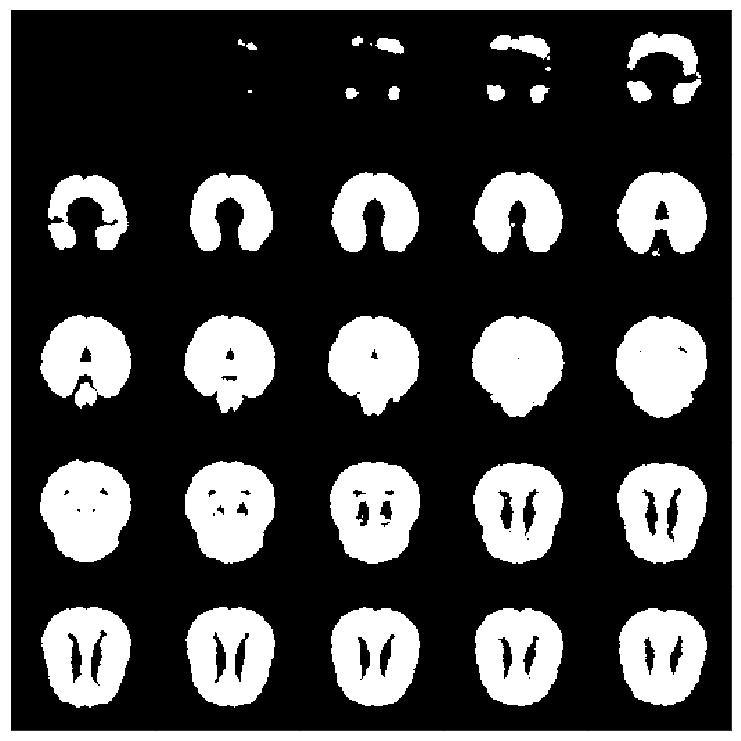

In [9]:
# Display the mask
fig = utils.slice_3d_array(mask, 0)

The other notebook will have a lot more to say about masking; for now, we will just walk through a few examples of how to unmask the data in the stored arrays (i.e., how to convert that data from an array of (time x voxels) to an array in the shape of a brain (time x Z x Y x X). 

For our first exmaple, just for funzies, let's visualize the estimated responses to one stimulus in the estimation data set.

In [13]:
a = np.array([1,2,3,4])
b = np.array([True, False, True, False])
a[b]

array([1, 3])

In [14]:
a[b] = 0
a

array([0, 2, 0, 4])

In [12]:
mask.sum()

65242

In [11]:
Y_est[0].shape

(65242,)

In [28]:
subject = 's01'
transform = 'color_natims' 
vol = cx.Volume(Y_est[0], subject, transform, 
                vmin=-3, vmax=3, cmap="RdBu_r", mask=mask)

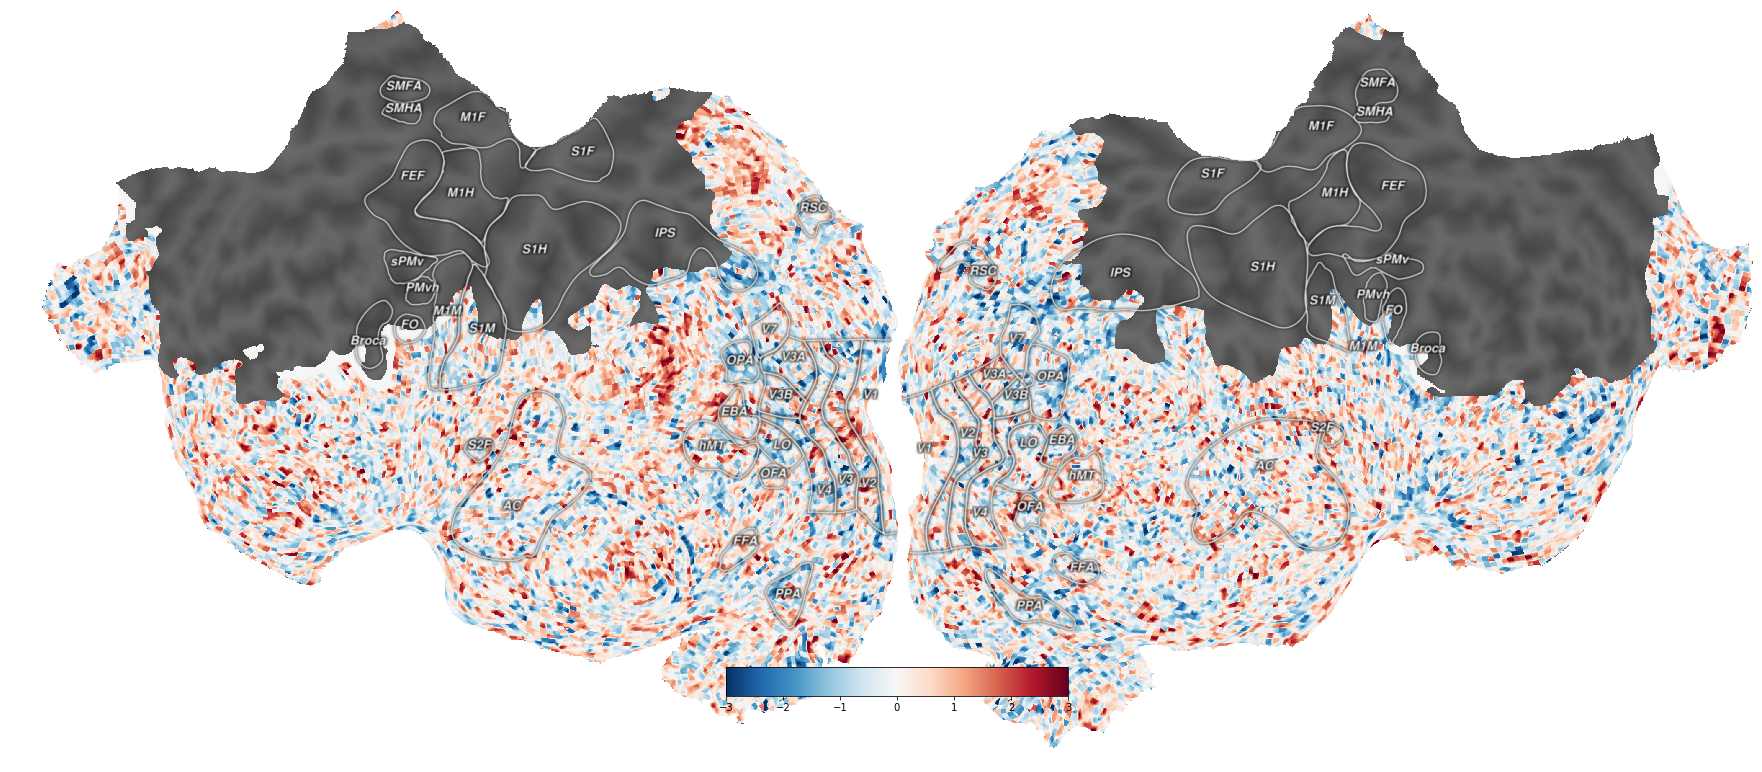

In [29]:
# Show responses in 2D flatmap with "quickflat" module
fig = cx.quickflat.make_figure(vol, with_curvature=True)

In [30]:
# Show responses in 3D in webgl viewer in your browser
h = cx.webgl.show(vol, open_browser=False)

Started server on port 15080


Stopping server


# Noise ceiling
OK! now on to noise ceilings! The simplest way to compute a noise ceiling is to simply correlate the responses to each image in the validation data. The first dimension of Y_val_rpts is the repeat dimension (there are 11 different estimated responses to all images). 

## Exercise 
Select each repeat in in turn, and correlate the responses across images with the other repeats using `utils.column_corr()`. There are many possible combinations of repeats! A great way to list all those combinations is with a library called `itertools`; check out the `itertools.combinations()` function.



In [31]:
Y_val_rpts.shape

(11, 126, 65242)

In [38]:
rpt_1 = Y_val_rpts[0, :, :]
rpt_2 = Y_val_rpts[1, :, :]
corr_r1_r2 = utils.column_corr(rpt_1, rpt_2)

In [39]:
corr_r1_r2.shape

(65242,)

In [40]:
corr_vol = cx.Volume(corr_r1_r2, subject, transform, vmin=0, vmax=0.4, 
                    cmap='inferno')

cx.webgl.show(corr_vol, open_browser=False)

In [32]:
import itertools as itools

In [33]:
itools.combinations?

In [43]:
# NICE!
combos = itools.combinations(np.arange(11), 2)
list(combos)
# How can you use this in your answer??

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (7, 8),
 (7, 9),
 (7, 10),
 (8, 9),
 (8, 10),
 (9, 10)]

In [44]:
# Answer
noise_ceil = utils.compute_noise_ceil(Y_val_rpts)

In [46]:
utils.compute_noise_ceil??

In [45]:
noise_ceill.shape

(65242,)

In [47]:
corr_vol = cx.Volume(noise_ceil, subject, transform, vmin=0, vmax=0.4, 
                    cmap='inferno')
cx.webgl.show(corr_vol, open_browser=False)

Started server on port 45500


<WebApp(Thread-7, started 139721764005632)>

## Exercise 
Show the noise ceiling on the brain! Use pycortex (`cx.Volume()`, and `cx.quickflat.make_figure()` or `cx.webgl.show()`) to display the data vector you have on the brain.

In [ ]:
# Answer


## Bonus exercise (we won't stop for this, but see if you can do it)
Put the estimated noise ceiling (which exists as a vector of values) back into a 3D volume, and display the image in slices as was done with the mask above!

In [ ]:
# Answer


# Making predictions of the validation data
To fit the models and make predictions of the validation data, we need our design matrices for each invidivdual model. These are stored in `color_natims_features_<model>.hdf` files. You can load them as we loaded the data above:

In [48]:
fname_base = '/unrshare/LESCROARTSHARE/IntroToEncodingModels/color_natims_features_%s.hdf'
with h5py.File(fname_base%'19cat') as hf:
    Xsem_est = hf['est'].value
    Xsem_val = hf['val'].value

with h5py.File(fname_base%'fft') as hf:
    Xfft_est = hf['est'].value
    Xfft_val = hf['val'].value

with h5py.File(fname_base%'dst') as hf:
    Xdst_est = hf['est'].value
    Xdst_val = hf['val'].value

In [49]:
# Check on some shapes of arrays to see if this is all sensible:
Xdst_val.shape

(126, 5)

<Container object of 19 artists>

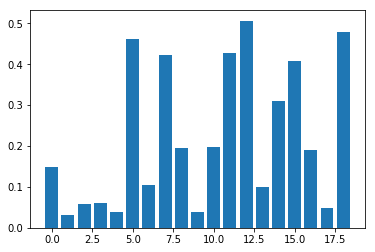

In [52]:
plt.bar(np.arange(19), Xsem_est.mean(0))

Now, this is pretty easy from here, since we don't have to worry about the HRF - the estimated responses for each image area already based on multiple presentations of the image, so the HRF has already been factored in. Now, we just do a regression of these feature values onto the Y values:

In [ ]:
# Define a simple regresion function
def simple_ols(X, Y):
    return np.linalg.pinv(X.T.dot(X)).dot(X.T.dot(Y))

We will start with the smallest model, the distance model:

In [ ]:
# Estimate beta weights
Bdst = simple_ols(Xdst_est, Y_est)

In [ ]:
# See what shape you get out. Is this sensible?
Bdst.shape

# Exercise
Plot the differences in beta values between the nearest distance and the farthest distance across the brain! This will make something like Figure 6A from the paper.

In [ ]:
# Answer


In [ ]:
## Predict the validation responses based on the distance model
Yhat_dst = Xdst_val.dot(Bdst)
r_dst = utils.column_corr(Yhat_dst, Y_val)

In [ ]:
# Get rid of nasty nans
r_dst[np.isnan(r_dst)] = 0
# And plot a histogram of prediction accuracy
_ = plt.hist(r_dst, bins=31)

## Exercise 
Show prediction accuracy in the brain!

In [ ]:
# Answer


## Exercise
Compute r_sem and r_fft, the prediction accuracy for the other two models. Also, compute r_dst_sem, the prediction accuracy for a COMBINED model of distance and semantic selectivity. To create the X variable that you will use in regression for these models, simply concatenate the X variables for the distance and semantic feature spaces in the features dimension, and re-fit!

In [ ]:
# Answer


# Variance partitioning 
For simplicity, we will only do variace partitioning between two models: the distance and semantic feature spaces. We will ultimately partly re-create part of figure 8 from the paper.

In [ ]:
# Lazy computation of r2
r2_dst = np.sign(r_dst) * r_dst**2
r2_sem = np.sign(r_sem) * r_sem**2
r2_dst_sem = np.sign(r_dst_sem) * r_dst_sem**2

# Variance partitioning
r2_unique_dst = r2_dst_sem - r2_sem
r2_unique_sem = r2_dst_sem - r2_dst
r2_shared = r2_dst_sem - r2_unique_dst - r2_unique_sem

# Show shared variance
fig1 = cx.quickflat.make_figure(cx.Volume(r2_shared, subject, transform, cmap='hot', mask=mask, vmin=0, vmax=0.2), with_curvature=True)
fig1.gca().set_title('Shared variance')
# Show unique variance for the semantic model
fig2 = cx.quickflat.make_figure(cx.Volume(r2_unique_sem, subject, transform, cmap='hot', mask=mask, vmin=0, vmax=0.2), with_curvature=True)
fig2.gca().set_title('Unique semantic variance')
# Show unique variance for the distance model
fig3 = cx.quickflat.make_figure(cx.Volume(r2_unique_dst, subject, transform, cmap='hot', mask=mask, vmin=0, vmax=0.2), with_curvature=True)
fig3.gca().set_title('Unique distance variance')

# Demo: Make ROI plots
... Will be done in class.

In [ ]:
roi_m = cx.get_roi_masks(subject, transform, roi_list=['V1','FFA','PPA','RSC','OPA'])